In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    MultiHeadAttention, LayerNormalization, Add, Dense, Conv1D, Concatenate,
    Input, Embedding, Dropout, LSTM, Bidirectional, TimeDistributed, BatchNormalization
)
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

In [2]:
!wget https://www.dropbox.com/scl/fi/ln64xjqlwd4665u9sp2bq/Full_Dataset.rar?rlkey=g5aa4zefy2xpj98n3x8ihjcp2&st=bg907w5p&dl=0
!mv Full_Dataset.rar?rlkey=g5aa4zefy2xpj98n3x8ihjcp2 Full_Dataset.rar
!unrar x /content/Full_Dataset.rar

Streaming output truncated to the last 5000 lines.
Extracting  Full_Dataset/55.txt                                           72%  OK 
Extracting  Full_Dataset/550.txt                                          72%  OK 
Extracting  Full_Dataset/5500.txt                                         72%  OK 
Extracting  Full_Dataset/5501.txt                                         72%  OK 
Extracting  Full_Dataset/5502.txt                                         72%  OK 
Extracting  Full_Dataset/5503.txt                                         72%  OK 
Extracting  Full_Dataset/5504.txt                                         72%  OK 
Extracting  Full_Dataset/5505.txt                                         72%  OK 
Extracting  Full_Dataset/5506.txt                                         72%  OK 
Extracting  Full_Dataset/5507.txt                                         72%  OK 
Extracting  Full_Dataset/5508

In [3]:
!wget https://raw.githubusercontent.com/HaniehP/PersianNER/refs/heads/master/glove300d.txt.zip
!unzip /content/glove300d.txt.zip

--2024-12-08 16:03:41--  https://raw.githubusercontent.com/HaniehP/PersianNER/refs/heads/master/glove300d.txt.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53542816 (51M) [application/zip]
Saving to: ‘glove300d.txt.zip’

glove300d.txt.zip   100%[===================>]  51.06M   127MB/s    in 0.4s    

2024-12-08 16:03:42 (127 MB/s) - ‘glove300d.txt.zip’ saved [53542816/53542816]

Archive:  /content/glove300d.txt.zip
  inflating: glove300d.txt           


In [4]:
# Path to the folder containing the text files
folder_path = 'Full_Dataset'

# Initialize empty lists to store text and labels
raw_train_ds = []
labels_ds = []

# List the files in the folder
files = os.listdir(folder_path)

# Iterate over the first 10 files
for file_name in files:
    # Construct the full path to the file
    file_path = os.path.join(folder_path, file_name)

    # Open the text file in read mode with UTF-8 encoding
    with open(file_path, 'r', encoding='utf-8') as file:
        # Initialize empty strings to store text and label for current file
        text = ''
        label = []

        # Iterate through each line in the file
        for line in file:
            # Get the last character of the line
            last_char = line.strip()[-1:]
            # Append the last character to the label
            label.append(int(last_char))

            # Get the rest of the line (excluding the last character)
            rest_of_line = line.strip()[:-1]
            # Append the rest of the line to the text
            text += rest_of_line

        # Append the text and label for the current file to the lists
        raw_train_ds.append(text)
        labels_ds.append(label)

In [5]:
train_size = 0.8

size = len(raw_train_ds)

train_samples = int(size * train_size)

x_train, y_train = raw_train_ds[:train_samples], labels_ds[:train_samples]
x_valid, y_valid = raw_train_ds[train_samples:], labels_ds[train_samples:]

In [6]:
# Load GloVe embeddings
embedding_index = {}
with open('glove300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        try:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
        except ValueError:
            continue

In [12]:
# Parameters
max_tokens = 10000
output_sequence_length = 60
embedding_dim = 300
num_classes = len(set([label for sublist in y_train for label in sublist]))

In [13]:
# Create TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)
vectorize_layer.adapt(x_train)

In [14]:
# Vectorize and pad labels
x_train_vectorized = vectorize_layer(x_train)
x_valid_vectorized = vectorize_layer(x_valid)

y_train_padded = tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=output_sequence_length, padding='post')
y_valid_padded = tf.keras.preprocessing.sequence.pad_sequences(y_valid, maxlen=output_sequence_length, padding='post')

In [15]:
# Create embedding matrix
vocab = vectorize_layer.get_vocabulary()
word_index = {word: i for i, word in enumerate(vocab)}
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
# Define a modified transformer block with CNN integration
def enhanced_transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout
    )(inputs, inputs)
    attention_output = Add()([attention_output, inputs])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Parallel CNN paths
    conv1 = Conv1D(filters=ff_dim//2, kernel_size=3, padding='same', activation='relu')(attention_output)
    conv2 = Conv1D(filters=ff_dim//2, kernel_size=5, padding='same', activation='relu')(attention_output)

    # Combine CNN outputs
    x = Concatenate()([conv1, conv2])
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)

    # Feed-forward network
    x = Dense(ff_dim, activation='relu')(x)
    x = Dense(inputs.shape[-1])(x)
    x = Add()([x, attention_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

In [22]:
# Define the enhanced model
input = Input(shape=(output_sequence_length,))
embedding_layer = Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=output_sequence_length,
    trainable=True
)(input)

# Initial dropout
x = Dropout(0.1)(embedding_layer)

# Enhanced transformer blocks with matching dimensions
x = enhanced_transformer_block(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)
x = enhanced_transformer_block(x, head_size=64, num_heads=8, ff_dim=256, dropout=0.1)

# Project to match LSTM dimensions (256 = 128 * 2 for bidirectional)
x = Dense(256)(x)

# Bidirectional LSTM layers with matching dimensions
lstm1 = Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.1))(x)
x = Add()([x, lstm1])  # Now dimensions match (both are 256)
x = LayerNormalization(epsilon=1e-6)(x)

lstm2 = Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.1))(x)
x = Add()([x, lstm2])
x = LayerNormalization(epsilon=1e-6)(x)

# Output layers with gradual dimension reduction
x = TimeDistributed(Dense(256, activation='relu'))(x)
x = Dropout(0.1)(x)
x = TimeDistributed(Dense(128, activation='relu'))(x)
x = LayerNormalization(epsilon=1e-6)(x)
output = TimeDistributed(Dense(num_classes, activation='softmax'))(x)

model = Model(inputs=input, outputs=output)


# Enhanced focal loss with dynamic class weighting
def adaptive_focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=num_classes)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Dynamic class weighting based on batch statistics
        pos_samples = tf.reduce_sum(y_true_one_hot[..., 1])
        total_samples = tf.cast(tf.size(y_true), tf.float32)
        pos_weight = tf.maximum(1.0, (total_samples - pos_samples) / (pos_samples + 1e-7))

        # Combine with focal loss
        weights = y_true_one_hot * pos_weight + (1 - y_true_one_hot)
        focal_weights = weights * tf.pow(1 - y_pred, gamma)

        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)
        loss = focal_weights * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss

# Compile with optimized settings
model.compile(
    optimizer=tf.keras.optimizers.AdamW(  # Using AdamW for better regularization
        learning_rate=1e-4,
        weight_decay=1e-5,
        clipnorm=1.0
    ),
    loss=adaptive_focal_loss(gamma=2.0, alpha=0.75)
)

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 60)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 60, 300)        │      3,000,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 60, 300)        │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 60, 300)        │        308,268 │ dropout_7[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 60, 300)        │              0 │ multi_head_attention_… │
│                           │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 60, 300)        │            600 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 60, 128)        │        115,328 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 60, 128)        │        192,128 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 60, 256)        │              0 │ conv1d_6[0][0],        │
│ (Concatenate)             │                        │                │ conv1d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 60, 256)        │          1,024 │ concatenate_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 60, 256)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 60, 256)        │         65,792 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 60, 300)        │         77,100 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 60, 300)        │              0 │ dense_5[0][0],         │
│                           │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 60, 300)        │            600 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_

 Total params: 5,795,410 (22.11 MB)

 Trainable params: 5,794,386 (22.10 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [24]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Define a custom callback for precision, recall, F1-score, and accuracy per sentence
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = self.validation_data
        y_pred = self.model.predict(val_x)

        # Convert predictions to class labels
        y_pred_classes = y_pred.argmax(axis=-1)

        # Flatten the arrays for token-level metrics
        val_y_flat = val_y.flatten()
        y_pred_flat = y_pred_classes.flatten()

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(val_y_flat, y_pred_flat)
        TP = conf_matrix[1, 1]
        FP = conf_matrix[0, 1]
        FN = conf_matrix[1, 0]

        # Precision, Recall, and F1-Score for Class 1
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        # Calculate sentence-level accuracy
        correct_sentences = np.all(val_y == y_pred_classes, axis=1)  # Compare token-level labels for each sentence
        sentence_accuracy = np.mean(correct_sentences)  # Percentage of completely correct sentences

        # Print metrics
        print(f"\nEpoch {epoch + 1}:")
        print(f"Precision (Class 1): {precision:.4f}, Recall (Class 1): {recall:.4f}, F1-Score (Class 1): {f1:.4f}")
        print(f"Sentence-Level Accuracy: {sentence_accuracy:.4f}")


In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

In [29]:
# Train the model
batch_size = 64
epochs = 7  # Increased number of epochs for better training

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_vectorized, y_train_padded)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid_vectorized, y_valid_padded)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

metrics_callback = MetricsCallback(validation_data=(x_valid_vectorized, y_valid_padded))

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1,
    callbacks=[metrics_callback, early_stopping]
)

Epoch 1/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step

Epoch 1:
Precision (Class 1): 0.7242, Recall (Class 1): 0.6374, F1-Score (Class 1): 0.6780
Sentence-Level Accuracy: 0.8325
229/229 ━━━━━━━━━━━━━━━━━━━━ 130s 569ms/step - loss: 0.4396 - val_loss: 0.5305
Epoch 2/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step

Epoch 2:
Precision (Class 1): 0.7748, Recall (Class 1): 0.6144, F1-Score (Class 1): 0.6853
Sentence-Level Accuracy: 0.8380
229/229 ━━━━━━━━━━━━━━━━━━━━ 131s 571ms/step - loss: 0.3850 - val_loss: 0.6702
Epoch 3/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step

Epoch 3:
Precision (Class 1): 0.7739, Recall (Class 1): 0.6226, F1-Score (Class 1): 0.6901
Sentence-Level Accuracy: 0.8459
229/229 ━━━━━━━━━━━━━━━━━━━━ 132s 579ms/step - loss: 0.3419 - val_loss: 0.6089
Epoch 4/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step

Epoch 4:
Precision (Class 1): 0.7638, Recall (Class 1): 0.6226, F1-Score (Class 1): 0.6860
Sentence-Level Accuracy: 0.8440
229/229 ━━━━━━━━━━━━━━━━━━━━ 134s 542ms/step - loss:

In [30]:
# Predict on validation set
y_pred = model.predict(x_valid_vectorized).argmax(axis=-1)

# Flatten the arrays for token-level metrics
val_y_flat = y_valid_padded.flatten()
y_pred_flat = y_pred.flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_y_flat, y_pred_flat)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Precision, Recall, and F1-Score for Class 1
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Sentence-Level Accuracy
correct_sentences = np.all(y_valid_padded == y_pred, axis=1)  # Check if all tokens in each sentence are correct
sentence_accuracy = np.mean(correct_sentences)  # Percentage of completely correct sentences

# Print metrics
print(f'Validation Precision (Class 1): {precision:.4f}')
print(f'Validation Recall (Class 1): {recall:.4f}')
print(f'Validation F1-Score (Class 1): {f1:.4f}')
print(f'Sentence-Level Accuracy: {sentence_accuracy:.4f}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step
Validation Precision (Class 1): 0.7242
Validation Recall (Class 1): 0.6374
Validation F1-Score (Class 1): 0.6780
Sentence-Level Accuracy: 0.8325


In [33]:
# Define the function to preprocess and predict NER tags for a single input string
def predict_ner_tags(input_string, vectorize_layer, model, max_length=60):
    # Tokenize the input string
    tokenized_input = input_string.split()

    # Vectorize the tokenized input
    input_vectorized = vectorize_layer(' '.join(tokenized_input))

    # Pad the vectorized input to the same length as used during training
    input_vectorized = tf.keras.preprocessing.sequence.pad_sequences([input_vectorized], maxlen=max_length, padding='post')

    # Make predictions
    predictions = model.predict(input_vectorized)

    # Post-process predictions to get the labels
    predicted_labels = tf.argmax(predictions, axis=-1).numpy()[0]

    # Only show labels for the original input length
    return list(zip(tokenized_input, predicted_labels[:len(tokenized_input)]))

In [34]:
# Example usage of the prediction function
input_sentences = [
    "مهدی صالحی، وزیر صنعت، معدن و تجارت، امروز به دیدار علیرضا رحیمی مدیر فناوری اطلاعاتی رفت.",
    "دکتر حسینی، استاد دانشگاه تهران، در مورد تکنیک‌های یادگیری عمیق مقاله‌ای منتشر کرد.",
    "فرزاد نوری، مدیر عامل شرکت ارتباطات پیشرفته، از آغاز طرح جدید خود خبر داد.",
    "دانیال نیکو، بازیکن تیم ملی فوتبال ایران، به خاطر حضور در مسابقات بین‌المللی تشویق شد.",
    "سوسن افشار، بازیگر معروف سینما و تلویزیون، امشب در برنامه خندوانه حاضر خواهد شد.",
    "حسن روحانی ، به روحانی محل ، رشوه داد .",
]
for input_string in input_sentences:
    predicted_ner_tags = predict_ner_tags(input_string, vectorize_layer, model)

    # Print the results
    for word, label in predicted_ner_tags:
        print(f"{word}: {label}")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
مهدی: 1
صالحی،: 1
وزیر: 0
صنعت،: 0
معدن: 0
و: 0
تجارت،: 0
امروز: 0
به: 0
دیدار: 0
علیرضا: 1
رحیمی: 1
مدیر: 0
فناوری: 0
اطلاعاتی: 0
رفت.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
دکتر: 0
حسینی،: 1
استاد: 0
دانشگاه: 0
تهران،: 0
در: 0
مورد: 0
تکنیک‌های: 0
یادگیری: 0
عمیق: 0
مقاله‌ای: 0
منتشر: 0
کرد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
فرزاد: 1
نوری،: 1
مدیر: 0
عامل: 0
شرکت: 0
ارتباطات: 0
پیشرفته،: 0
از: 0
آغاز: 0
طرح: 0
جدید: 0
خود: 0
خبر: 0
داد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
دانیال: 1
نیکو،: 1
بازیکن: 0
تیم: 0
ملی: 0
فوتبال: 0
ایران،: 0
به: 0
خاطر: 0
حضور: 0
در: 0
مسابقات: 0
بین‌المللی: 0
تشویق: 0
شد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
سوسن: 1
افشار،: 1
بازیگر: 0
معروف: 0
سینما: 0
و: 0
تلویزیون،: 0
امشب: 0
در: 0
برنامه: 0
خندوانه: 0
حاضر: 0
خواهد: 0
شد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
حسن: 1
روحانی: 1
،: 0
به: 0
روحانی: 0
محل: 0
،: 0
رشوه: 0
داد: 0
.: 0



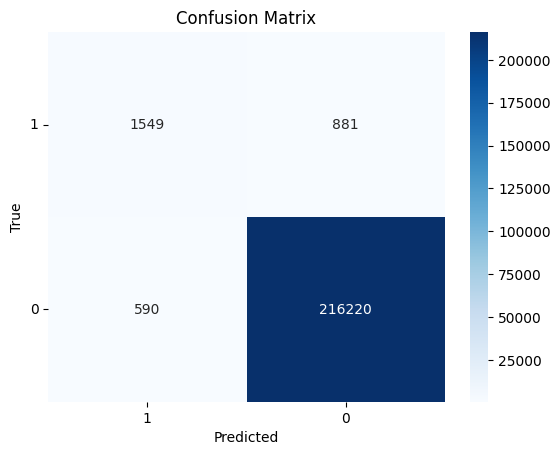

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true_flat = y_valid_padded.flatten()
y_pred_flat = y_pred.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Swap rows and columns to change the order
cm = cm[[1, 0], :]  # Swap rows
cm = cm[:, [1, 0]]  # Swap columns

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0.5, 1.5], ['1', '0'])  # Update x-axis labels
plt.yticks([0.5, 1.5], ['1', '0'], rotation=0)  # Update y-axis labels
plt.show()


In [36]:
import pickle

# Save all necessary data
training_data = {
    'x_train': x_train,
    'vectorize_config': vectorize_layer.get_config(),  # تنها config را ذخیره می‌کنیم
    'vocabulary': vectorize_layer.get_vocabulary(),    # vocabulary را جداگانه ذخیره می‌کنیم
    'vectorize_weights': vectorize_layer.get_weights(),
    'embedding_matrix': embedding_matrix,
    'vocab_size': len(vocab),
    'max_tokens': max_tokens,
    'embedding_dim': embedding_dim,
    'max_sequence_length': output_sequence_length,
    'num_classes': num_classes,
    'head_size': 64,
    'num_heads': [4, 8],
    'ff_dim': 256,
    'units': 128
}


# Save the data
with open('version_5_0_3_training_data.pkl', 'wb') as f:
    pickle.dump(training_data, f)

# Save the model weights
model.save_weights('version_5_0_3.weights.h5')